In [1]:
'''
oriented-rcnn offset box representation

anchor = [x,y,w,h]
gt = [x,y,w,h,angle]

# transform
[x,y,w,h]       => [x,y,w,h,alpha,beta]
[x,y,w,h,angle] => [x,y,w,h,alpha,beta]
 

'''

'\noriented-rcnn offset box representation\n\nanchor = [x,y,w,h]\ngt = [x,y,w,h,angle]\n\n# transform\n[x,y,w,h]       => [x,y,w,h,alpha,beta]\n[x,y,w,h,angle] => [x,y,w,h,alpha,beta]\n \n\n'

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math 

#-------------------------------
anchor_box = [100,200, 300,300, 100,200]

x = anchor_box[0]
y = anchor_box[1]
width =  anchor_box[2] 
height = anchor_box[3]

#-------------------------------
gt_box = [700,200, 50,300, 40]

x_p = gt_box[0]
y_p = gt_box[1]
width_p = gt_box[2]
height_p = gt_box[3]
angle_p = gt_box[4]

In [3]:
# --- affine-transform and poly

# 0 convertinf to poly type
def convert_to_polygon(box):
    x, y, width, height = box[0:4]

    # Calculate the coordinates of the four corners
    x1, y1 = x-0.5*width, y-0.5*height
    x2, y2 = x-0.5*width, y+0.5*height
    x3, y3 = x+0.5*width, y+0.5*height
    x4, y4 = x+0.5*width, y-0.5*height

    # Create a list of points representing the polygon
    polygon = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

    return polygon

poly_gt = convert_to_polygon(gt_box)
poly_gt = np.array(poly_gt)



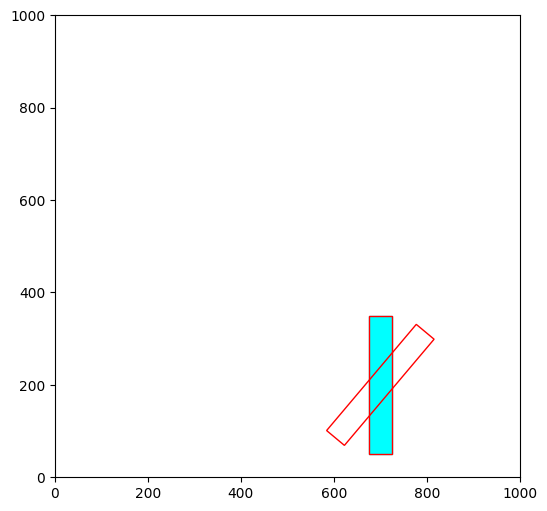

In [4]:
# -- poly convert verification & rotation

fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(
    patches.Polygon(poly_gt,color='cyan'),
)

ax.add_patch(
    patches.Rectangle([x_p-width_p*0.5, y_p-height_p*0.5],width=width_p,height=height_p,color='r',fill=False)

)

ax.add_patch(
    patches.Rectangle([x_p-width_p*0.5, y_p-height_p*0.5],width=width_p,height=height_p,color='r',fill=False,
                      angle= -angle_p,
                      rotation_point="center")

)
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()

In [5]:
# 1 move center to the origin 

poly_gt_xs = poly_gt[:,0] -x_p
poly_gt_ys = poly_gt[:,1] -y_p
result = [[x, y] for x, y in zip(poly_gt_xs, poly_gt_ys)]
result = np.array(result)
print(result.shape)

(4, 2)


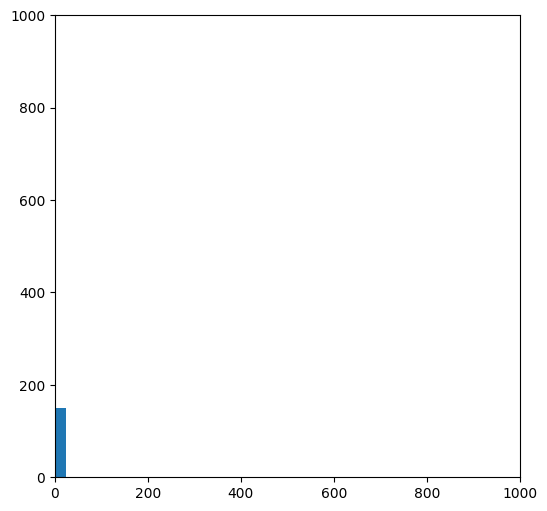

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(
    patches.Polygon(result)
)
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()

In [7]:
theta = angle_p
theta = theta * (np.pi / 180)
tx = x_p
ty = y_p 
#--------------------------------------
# clock-wise rotation 을 하기 위해서, (2,1) 에 있는 sin 에다가 minus 를 곱해주었다. 
matrix = np.array([
    [np.cos(theta) , np.sin(theta), tx],
    [-np.sin(theta),  np.cos(theta), ty],
    [0, 0, 1 ]])

matrix = np.transpose(matrix)
#--------------------------------------

result = [[x, y, 1] for x, y in zip(poly_gt_xs, poly_gt_ys)]
result = np.array(result)
rotated_result = result @ matrix

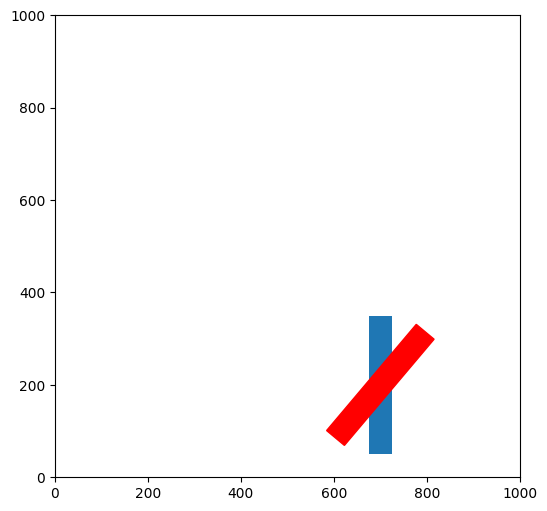

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.add_patch(
    patches.Polygon(poly_gt))

ax.add_patch(
    patches.Polygon(rotated_result[:,0:2],color='r'))

ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()

In [9]:
#-----
# get rectangle from rotated box

max_x = np.max(rotated_result[:,0:2][:,0]) 
min_x = np.min(rotated_result[:,0:2][:,0])
max_y = np.max(rotated_result[:,0:2][:,1])
min_y = np.min(rotated_result[:,0:2][:,1])

new_max_width = max_x - min_x
new_max_height = max_y - min_y

new_center_x = min_x + 0.5*new_max_width
new_center_y = min_y + 0.5*new_max_height


#----
mid_point_up  = [new_center_x, new_center_y + 0.5*new_max_height] 
mid_point_right  = [new_center_x + 0.5*new_max_width, new_center_y]

In [17]:
#------
# positive anchor box 

poly_anchor_gt = poly_gt[:] + 50 

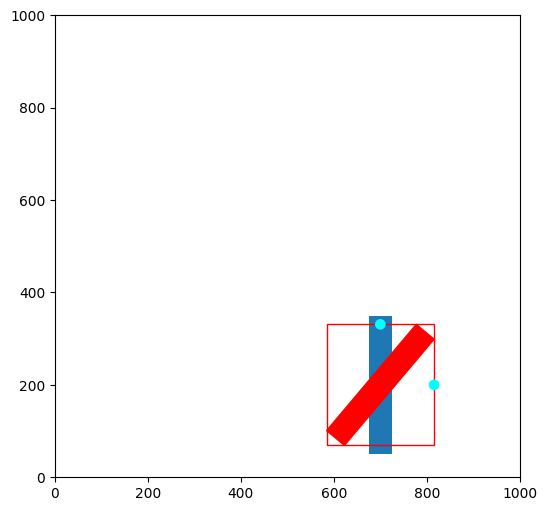

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.add_patch(
    patches.Polygon(poly_gt))

ax.add_patch(
    patches.Polygon(rotated_result[:,0:2],color='r'))

ax.add_patch(
    patches.Rectangle((new_center_x - 0.5*new_max_width,
                       new_center_y - 0.5*new_max_height),
                       width=new_max_width,
                       height=new_max_height,
                       fill=False,
                       color='r'))

ax.add_patch(
    patches.Circle(mid_point_up,radius=10,color='cyan')
)
ax.add_patch(
    patches.Circle(mid_point_right,radius=10,color='cyan')
)

ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()


In [24]:
poly_gt

array([[675.,  50.],
       [675., 350.],
       [725., 350.],
       [725.,  50.]])

In [25]:
rotated_result

array([[584.43074747, 101.16302377,   1.        ],
       [777.26703038, 330.97635671,   1.        ],
       [815.56925253, 298.83697623,   1.        ],
       [622.73296962,  69.02364329,   1.        ]])